# Import library

In [6]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [17]:
import sys, os 
import glob 
import pandas as pd
import numpy as np
import imageio
import PIL
import time 
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython import display

# Load MNIST datasets

In [9]:
# load the train images and their labels
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [11]:
print(f"Nb TRAIN images = {len(train_images)}")

Nb TRAIN images = 60000


In [14]:
print(f"Possible Train images labels: {np.unique(train_labels)}")

Possible Train images labels: [0 1 2 3 4 5 6 7 8 9]


*   Reshape all images on one size and one color channel as : (width, height, nb_color_channel)
*   Normalize the images to [-1, 1]

In [15]:
# normalization of data : 1 mean the images are cosidered as gray 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

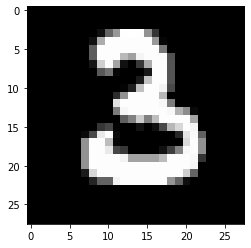

In [21]:
import random 
random_image = random.choice(train_images)
pixels = random_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

# Define the btach and shuffle the input datasets

In [22]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Build GANs

## 1-Build the Generator of the GANs
The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [28]:
# funtion to build the generator model  
def make_generator_model(img_width, img_height, img_color_channel):
    '''
    Create a sequential architecture of the generator.
    Args:
          img_width: the width of the image should be generated by the generator
          img_height: the height of the image should be generated by the generator
          img_color_channel: the number of color channel of the image should be generated by the generator
    Return:
          model: a sequential model of the generator
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_width, img_height, img_color_channel)

    return model

In [35]:
generator = make_generator_model(img_width=28, img_height=28, img_color_channel=1)
generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_21 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_22 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 7, 7, 128)        

## 2-Build the Descriminator of the GANs
The discriminator is a CNN-based image classifier.

In [38]:
def make_discriminator_model(input_img_width, input_img_height, input_img_color_channel):
    '''
    Create a sequential architecture of the discriminator.
    Args:
          img_width: the width of the input image
          img_height: the height of the input image
          img_color_channel: the number of color channel of the input image
    Return:
          model: a sequential model of the descriminator
    '''
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[input_img_width, input_img_height, input_img_color_channel]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [39]:
 discriminator = make_discriminator_model(input_img_width=28, input_img_height=28,input_img_color_channel=1)
 discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Test the genrator and the discriminator on an input images (just random noise)

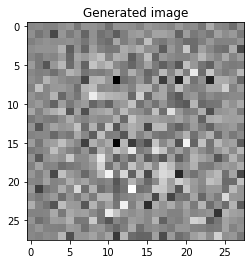

decision score of the discriminator = [[-0.00051418]]


In [44]:
# generate image using the generator
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# show example of generated images 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title('Generated image')
plt.show()
# Print the dicison score of the discriminator
decision = discriminator(generated_image)
print(f'decision score of the discriminator = {decision}')

## 3-Define the loss functiuon of the genrator and the discriminator

Define loss functions and optimizers for both models.

In [57]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # binary classes = Real or Fake image
# if we have multi classes we use categorical cross entropy 
#tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [58]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [59]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Genrator and discriminator optimizers

The discriminator and the generator optimizers are different since you will train two networks separately.



In [60]:
lr = 1e-4 # learning rate
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

# 4-Define functions ot launch training of GANs

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [61]:
model_name = 'gans_mnist'
checkpoint_dir = f'./{model_name}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop
The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [67]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [68]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [69]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [70]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# 5-Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.


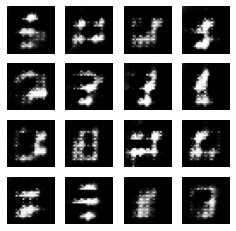

Time for epoch 2 is 651.0355520248413 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)